# Predicting Career Preparedness Across Cultures and Modalities

In [96]:
# Import Packages
import pandas as pd
from clean_task1 import load_data, relabel_factors, create_combined_factors
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
import statsmodels.formula.api as smf
import seaborn as sns
import numpy as np
from sklearn.linear_model import LassoCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from tuning import forward_selection
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from semopy import Model
from scipy import stats


# Set necessary configs
pd.set_option('display.max_columns', None)


In [25]:
# Read the data and select the headers
df = load_data("../data_source/CDS_25_Task1.xlsx")
df = relabel_factors(df)

In [26]:
# For demographic variables, what are the distributions of categories
print(df["Country"].value_counts())
print(df["Industry"].value_counts())
print(df["Gender"].value_counts())
print(df["Age"].value_counts())

Country
US    1204
UK     617
DE     613
IT     600
FR     593
SP     584
Name: count, dtype: int64
Industry
Fin       1797
Tech      1211
Energy     617
Pharma     586
Name: count, dtype: int64
Gender
Male                           2113
Female                         2062
Non-Binary / Non-Conforming      28
Prefer Not to Answer              7
Other                             1
Name: count, dtype: int64
Age
25-40    1493
41-64    1413
18-24    1305
Name: count, dtype: int64


In [27]:
# Understand the summary statistics of the quantitative data that has been provided
df.describe()

,"Extraverted, Enthusiastic.","Critical, Quarrelsome.","Dependable, Self-Disciplined.","Anxious, Easily Upset.","Open To New Experiences, Complex.","Sympathetic, Warm.","Disorganized, Careless.","Reserved, Quiet.","Calm, Emotionally Stable.","Conventional, Uncreative.",Preparedness Levels,lbalanx,lbalsat,lcntcom,lcntpsy,lconinc,lconsoc,lcontcon,lcontimp,lgen,ljouopt,ljoupro,lresfin,lresski,ltraaut,ltrades,lcarprom,lcollea,lenjhyb,lexcesswk,lfinlair,llearndev,lmeanfull,lpoorman,ltoxic,luseskills,lwellcomp,fbalanx,fbalsat,fcntcom,fcntpsy,fconinc,fconsoc,fcontcon,fcontimp,fgen,fjouopt,fjoupro,fresfin,fresski,ftraaut,ftrades,fcarprom,fcollea,fenjhyb,fexcesswk,ffinfair,flearndev,fmeanfull,fpoorman,ftoxic,fuseskills,fwellcomp
count,4211.00000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4210.000000,4210.000000,4211.000000,4210.000000,4211.000000,4211.000000,4210.000000,4211.000000,4210.000000,4211.000000,4211.000000,4211.000000,4211.000000,4209.000000,4210.000000,4210.000000,4210.000000,4211.000000,4209.000000,4206.000000,4211.000000,4211.000000,4210.000000,4210.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4208.000000,4209.000000,4211.000000
mean,4.95488,3.432201,5.818095,3.679886,5.606982,5.730705,2.909998,4.895987,5.493707,3.554738,7.472833,-4.779150,28.823320,24.691285,36.784612,36.731180,-15.685110,46.259796,55.414391,50.771788,33.994301,44.621230,37.431726,56.613631,48.705771,40.916647,69.644977,26.953218,72.239373,60.071259,44.358670,76.715744,73.705463,35.775350,39.076229,78.248219,62.651389,6.960553,26.744474,23.314619,17.681544,16.655882,4.194921,27.885788,38.644207,28.238600,21.896601,25.839528,25.425381,30.111985,29.060262,29.225229,69.037642,41.029522,64.422099,53.841680,49.683340,68.582701,66.819313,44.444233,49.103114,71.981701,63.888865
std,1.70241,1.941752,1.397373,1.971079,1.450412,1.343288,1.936577,1.702342,1.418957,1.909853,1.549455,59.445068,59.836365,55.240994,53.111753,54.523371,55.271944,48.958492,52.014756,49.591542,56.351282,52.926631,54.198323,48.156787,50.042610,54.595928,31.426853,32.728494,28.858047,33.850743,35.446842,27.610623,29.394357,36.010006,36.086813,26.880258,32.758645,36.595440,44.621083,41.344062,36.057745,40.645781,34.068648,37.079739,42.492728,36.911896,41.705553,38.899262,38.652429,37.228426,38.424302,39.021322,27.542660,26.091817,25.486879,30.178710,23.719157,25.985147,26.850804,29.558356,28.220659,25.287965,29.280311
min,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-94.444444,-96.666667,-98.888889,-97.222222,-98.888889,-98.888889,-96.666667,-98.888889,-96.666667,-96.666667,-98.888889,-98.888889,-98.888889,-96.111111,-98.888889,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.00000,2.000000,5.000000,2.000000,5.000000,5.000000,1.000000,4.000000,5.000000,2.000000,6.500000,-50.000000,0.000000,0.000000,0.000000,0.000000,-50.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,25.000000,0.000000,0.000000,50.000000,0.000000,50.000000,25.000000,0.000000,75.000000,50.000000,0.000000,0.000000,75.000000,50.000000,-17.777778,-4.444444,-5.555556,-6.111111,-10.277778,-18.888889,5.555556,10.000000,4.444444,-6.944444,0.000000,-1.111111,7.777778,5.555556,3.333333,54.444444,21.111111,51.679293,26.666667,34.444444,57.777778,54.444444,20.000000,26.666667,61.666667,40.000000
50%,5.00000,3.

In [28]:
# The qualitative summary statistics indicate that there are a very small number of missing rows, which will be dropped
df = df.dropna()

In [29]:
# Combine explicit and implicit factors together for new dataset
df = create_combined_factors(df)
df

,Batch Group,Country,Industry,Gender,Age,"Extraverted, Enthusiastic.","Critical, Quarrelsome.","Dependable, Self-Disciplined.","Anxious, Easily Upset.","Open To New Experiences, Complex.","Sympathetic, Warm.","Disorganized, Careless.","Reserved, Quiet.","Calm, Emotionally Stable.","Conventional, Uncreative.",Preparedness Levels,Unnamed: 14,lbalanx,lbalsat,lcntcom,lcntpsy,lconinc,lconsoc,lcontcon,lcontimp,lgen,ljouopt,ljoupro,lresfin,lresski,ltraaut,ltrades,lcarprom,lcollea,lenjhyb,lexcesswk,lfinlair,llearndev,lmeanfull,lpoorman,ltoxic,luseskills,lwellcomp,fbalanx,fbalsat,fcntcom,fcntpsy,fconinc,fconsoc,fcontcon,fcontimp,fgen,fjouopt,fjoupro,fresfin,fresski,ftraaut,ftrades,fcarprom,fcollea,fenjhyb,fexcesswk,ffinfair,flearndev,fmeanfull,fpoorman,ftoxic,fuseskills,fwellcomp,balanx,balsat,cntcom,cntpsy,coninc,consoc,contcon,contimp,gen,jouopt,joupro,resfin,resski,traaut,trades,carprom,collea,enjhyb,excesswk,finlair,learndev,meanfull,poorman,toxic,useskills,wellcomp
0,FR Tech,FR,Tech,Female,18-24,5,1,7,3,7,7,1,6,6,2,7.6,"Je suis prête à m’engager, organise",50,100,0,100,100,-100,0,100,100,50,75,75,100,100,100,100,0,75,100.0,0.0,100,100.0,25,100,100.0,100,45.000000,22.222222,51.111111,27.777778,37.777778,42.222222,52.777778,40.000000,-44.444444,56.666667,-11.111111,63.333333,78.888889,7.777778,32.777778,96.666667,15.555556,65.555556,25.555556,44.444444,86.666667,63.333333,20.000000,97.777778,91.666667,100.000000,47.500000,61.111111,25.555556,63.888889,68.888889,-28.888889,26.388889,70.000000,27.777778,53.333333,31.944444,69.166667,89.444444,53.888889,66.388889,98.333333,7.777778,70.277778,62.777778,22.222222,93.333333,81.666667,22.500000,98.888889,95.833333,100.000000
1,FR Tech,FR,Tech,Female,18-24,5,2,6,3,7,7,1,5,7,1,9.0,Jeune diplôme je suis prête à entrer dans le m...,-100,75,0,50,100,-100,75,100,100,100,75,50,75,100,100,0,25,25,100.0,25.0,100,100.0,75,50,100.0,0,-46.666667,80.000000,66.111111,22.222222,71.111111,-33.333333,58.888889,96.666667,38.888889,44.444444,45.555556,43.333333,44.444444,87.777778,47.222222,52.222222,48.888889,37.777778,57.777778,65.555556,76.666667,77.777778,92.222222,67.777778,93.333333,16.666667,-73.333333,77.500000,33.055556,36.111111,85.555556,-66.666667,66.944444,98.333333,69.444444,72.222222,60.277778,46.666667,59.722222,93.888889,73.611111,26.111111,36.944444,31.388889,78.888889,45.277778,88.333333,88.888889,83.611111,58.888889,96.666667,8.333333
2,FR Tech,FR,Tech,Female,18-24,2,3,1,4,2,2,5,4,4,3,4.5,"La nouvelle technologie, les nouveaux moyens m...",25,0,25,0,25,50,0,50,-25,25,50,75,100,25,50,50,50,50,75.0,50.0,50,50.0,50,50,75.0,50,-81.666667,18.333333,-95.555556,-16.111111,-65.555556,16.666667,-13.333333,-5.555556,32.222222,28.333333,71.111111,32.222222,8.888889,47.777778,39.444444,77.777778,86.666667,60.000000,56.666667,48.888889,76.666667,91.666667,30.000000,38.888889,72.222222,83.333333,-28.333333,9.166667,-35.277778,-8.055556,-20.277778,33.333333,-6.666667,22.222222,3.611111,26.666667,60.555556,53.611111,54.444444,36.388889,44.722222,63.888889,68.333333,55.000000,65.833333,49.444444,63.333333,70.833333,40.000000,44.444444,73.611111,66.666667
3,FR Tech,FR,Tech,Female,25-40,4,6,1,3,4,1,7,2,2,3,6.0,Je suis prete à passer a une nouvelle étape de...,0,50,0,-50,50,50,100,50,100,50,100,0,100,100,100,0,0,75,0.0,25.0,100,0.0,100,25,25.0,0,21.111111,70.000000,-18.888889,-18.888889,21.111111,15.555556,71.666667,50.000000,40.000000,58.888889,66.666667,61.111111,60.555556,57.777778,62.777778,94.444444,25.555556,62.222222,40.000000,27.777778,96.666667,21.111111,70.000000,20.000000,93.333333,22.777778,10.555556,60.000000,-9.444444,-34.444444,35.555556,32.777778,85.833333,50.000000,70.000000,54.444444,83.333333,30.555556,80.277778,78.888889,81.388889,47.222222,12.777778,68.611111,20.000000,26.388889,98.333333,10.555556,85.000000,22.500000,59.166667,11.388889
4,FR Tech,FR,Tech,Female,25-40,7,5,7,5,7,7,1,5,7,1,9.2,Sa fait 4ans que je suis en poste de chef d'é...,-25,100,0,-25,100,-100,-25,100,100,0,0,100,100,1

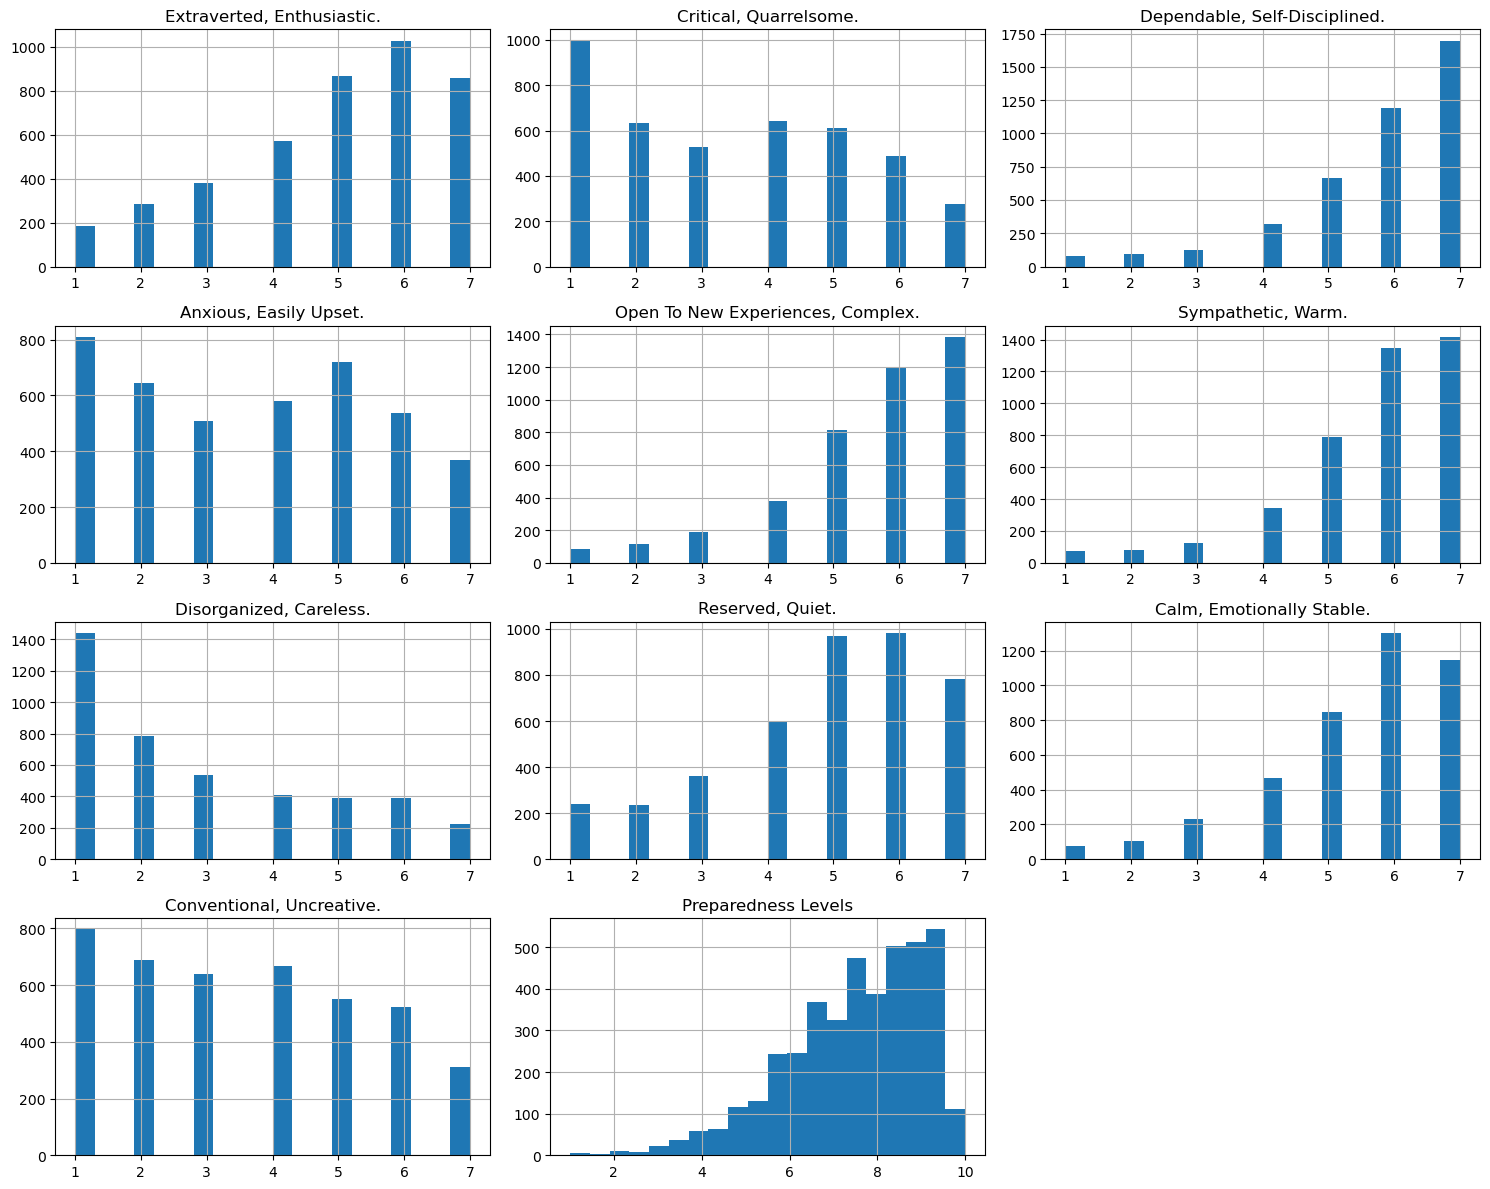

In [30]:
# Plot a matrix of histograms to inspect distribution of variables
df_subset = df.iloc[:, 5:16]
df_subset.hist(figsize=(15, 12), bins=20)

plt.tight_layout()
plt.show()

All personality factors are measured on a scale from 1-7, whilst the outcome variable 'Preparedness Levels' is from a scale of 1-10. 

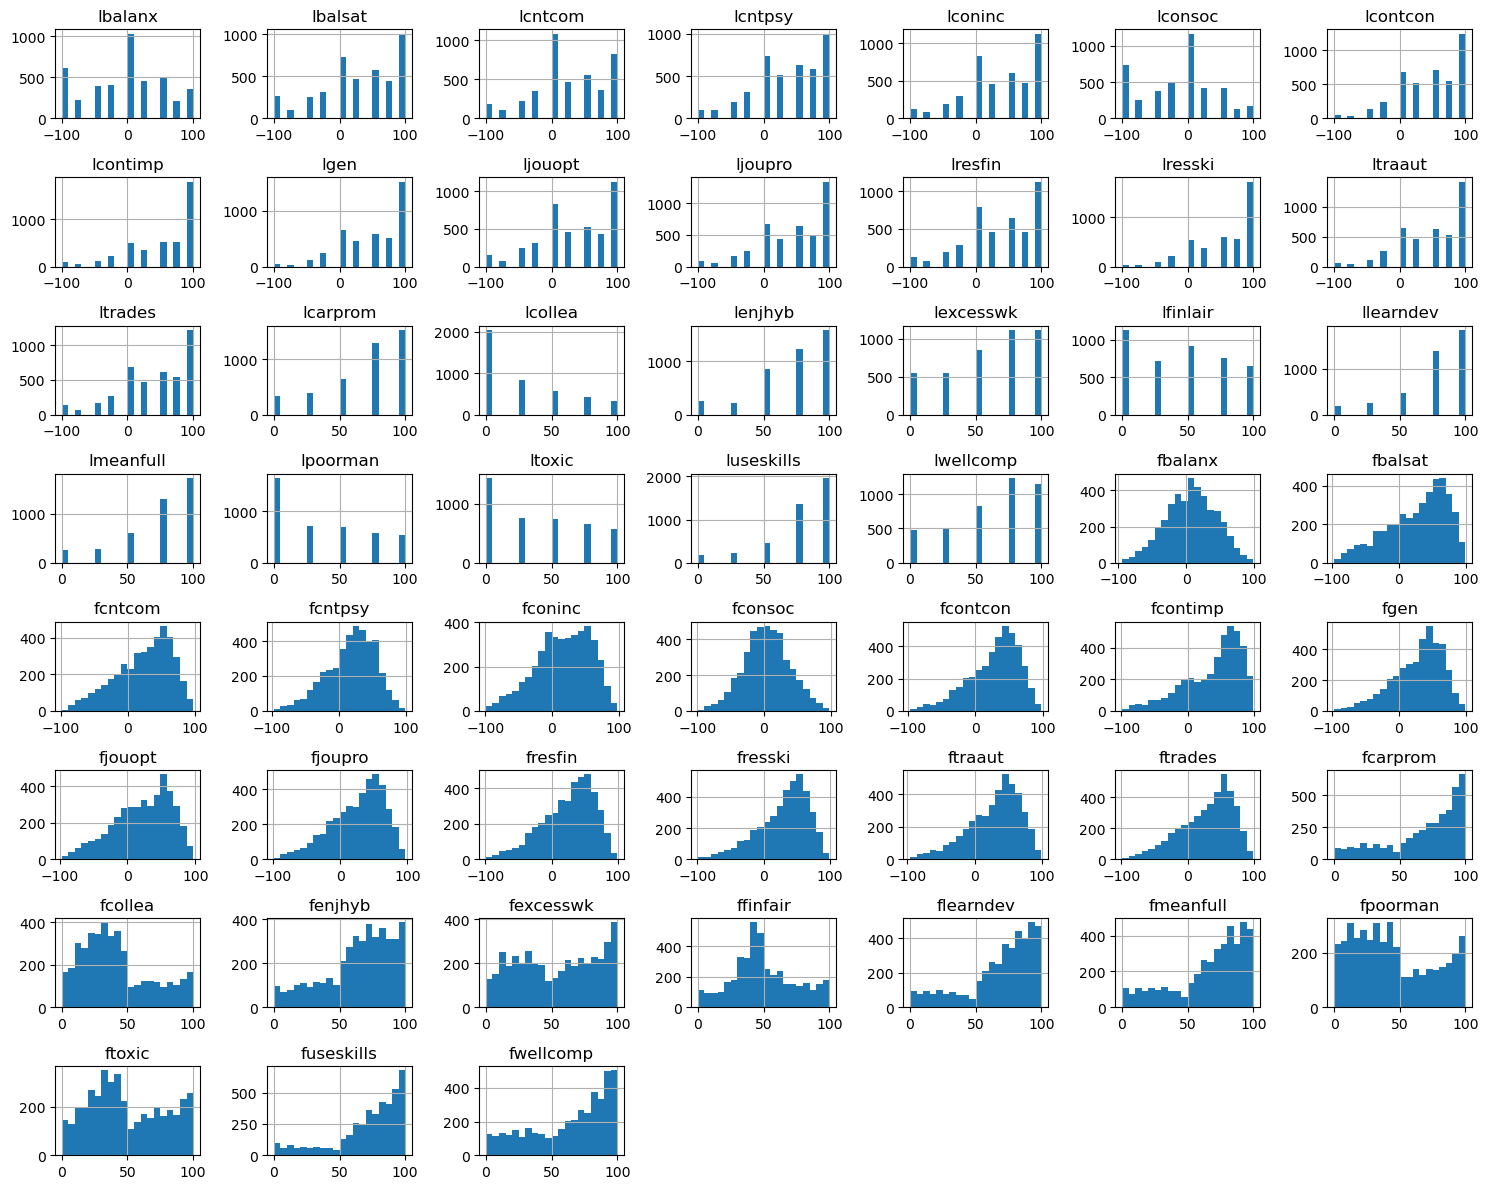

In [31]:
# Plot a matrix of histograms to inspect distribution of variables
df_subset = df.iloc[:, 16:69]
df_subset.hist(figsize=(15, 12), bins=20)

plt.tight_layout()
plt.show()

From plotting the distributions of the variables, two scales are clearly apparent:
1. Emotional/psychological variables are encoded on a scale from -100 to 100 for both implicit and explicit variables
2. Workplace/functional variables are encoded on a scale from 0 to 100 for both implicit and explicit variables

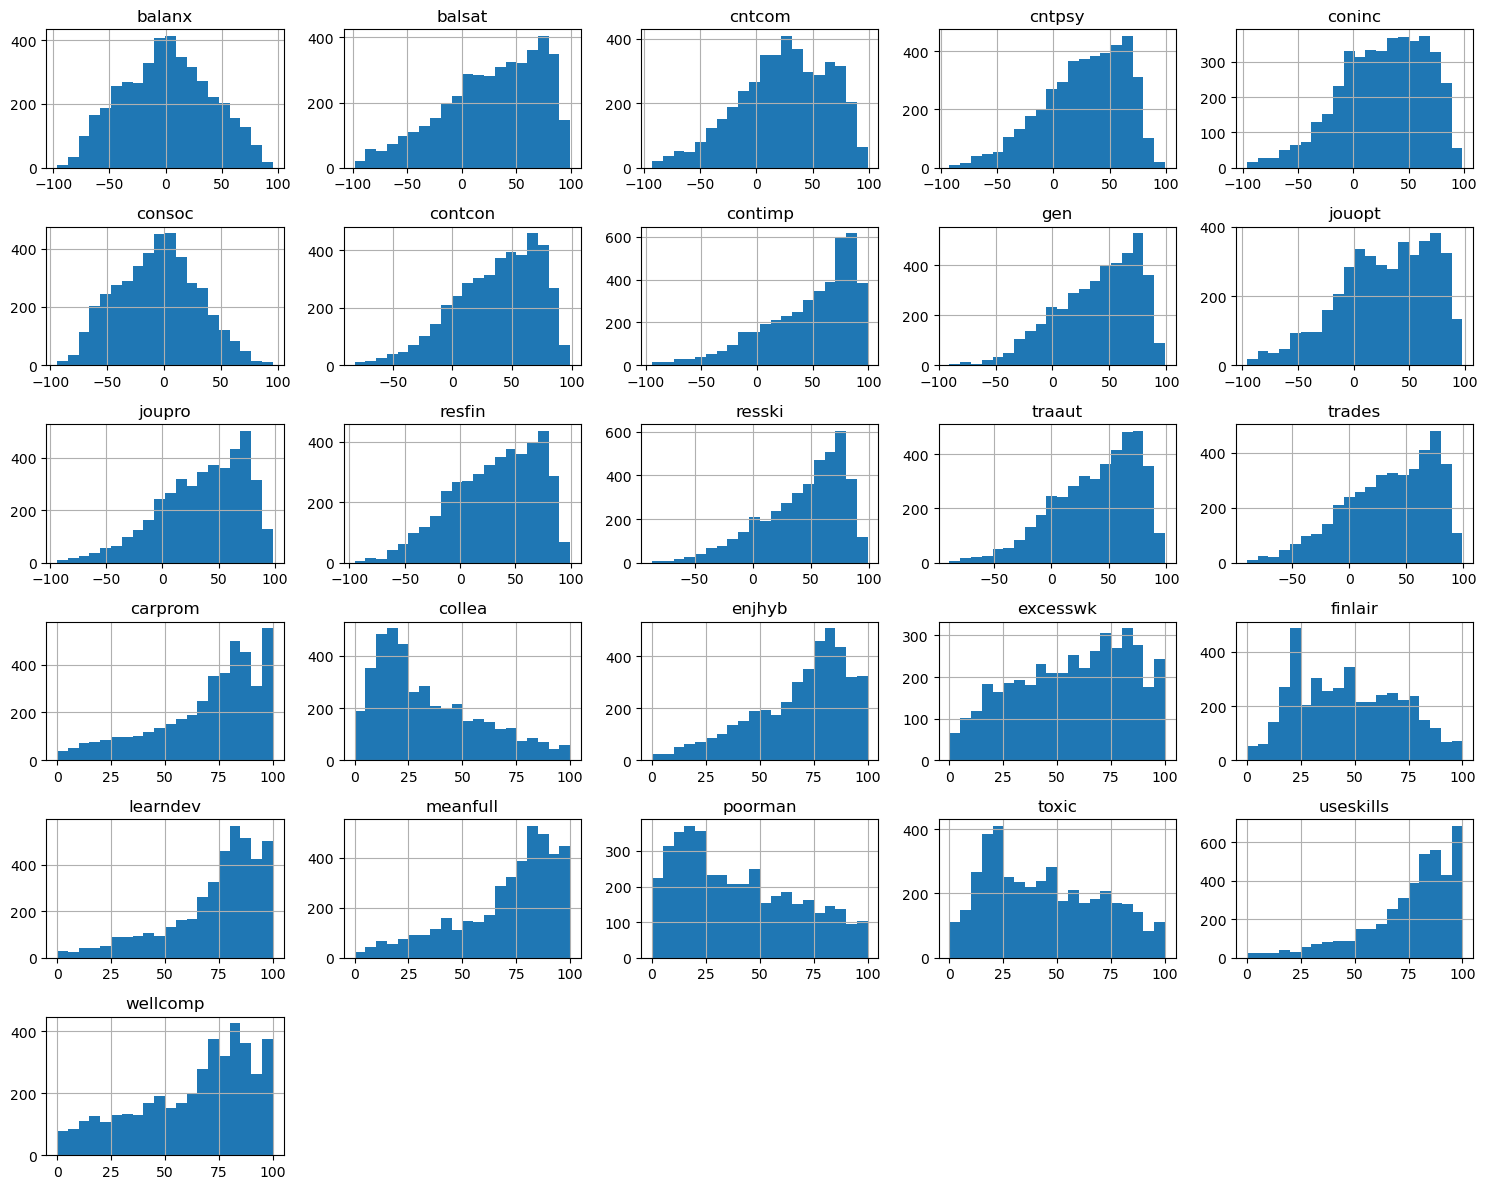

In [32]:
# Plot a matrix of histograms to inspect distribution of variables
df_subset = df.iloc[:, 69:]
df_subset.hist(figsize=(15, 12), bins=20)

plt.tight_layout()
plt.show()

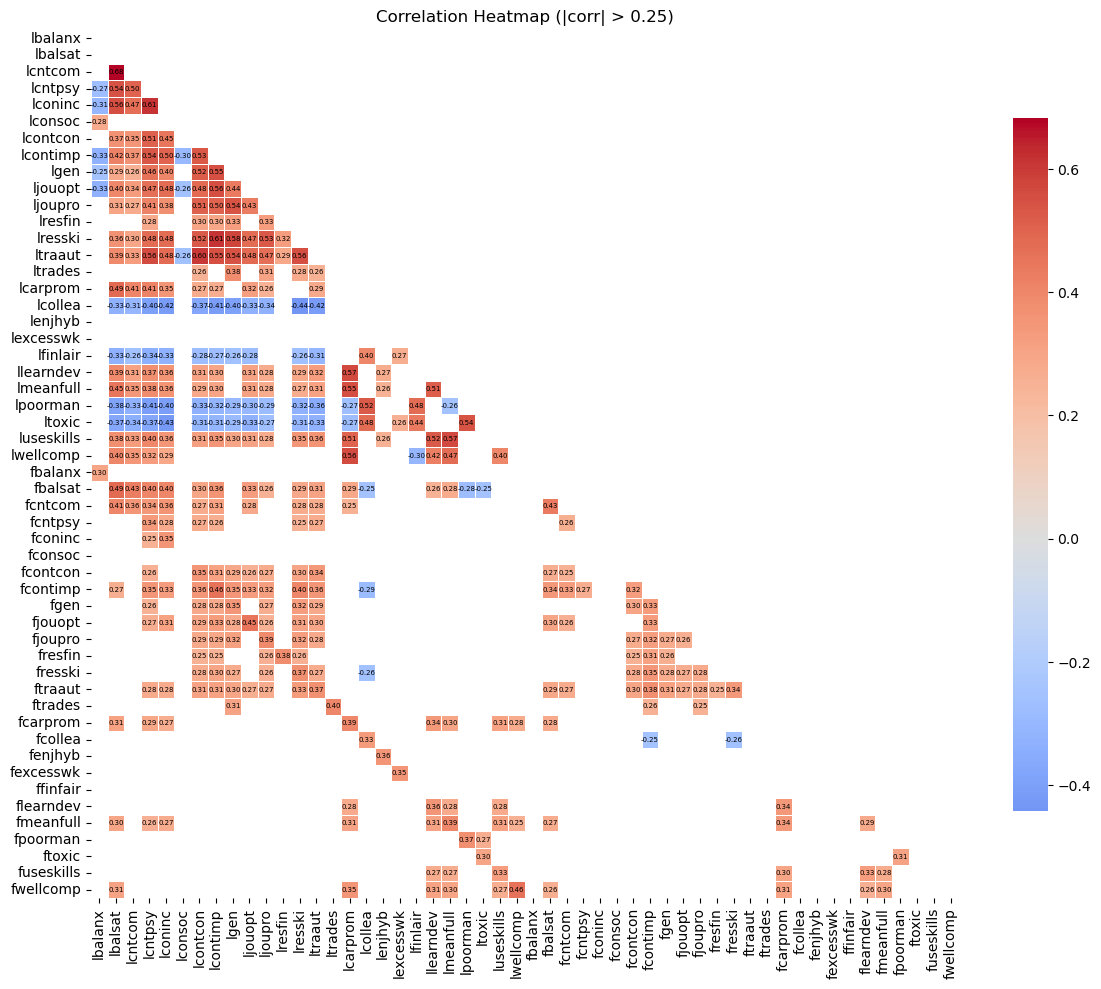

In [33]:
# Identify collinearity between variables
corr = df.iloc[:,17:69].corr()

threshold = 0.25
filtered_corr = corr.where(abs(corr) > threshold, other=np.nan)

mask = np.triu(np.ones_like(filtered_corr, dtype=bool))

plt.figure(figsize=(14,12))
sns.heatmap(
    filtered_corr,
    mask=mask,
    annot=True,
    annot_kws={"size": 5, "color": "black"},
    cmap='coolwarm',
    center=0,
    linewidths=0.5,
    cbar_kws={"shrink": 0.75},
    fmt=".2f",
    square=True
)
plt.title(f"Correlation Heatmap (|corr| > {threshold})")
plt.show()

In [34]:
for i, col in enumerate(df.columns):
    print(f"{i}: {col}")

0: Batch Group
1: Country
2: Industry
3: Gender
4: Age
5: Extraverted, Enthusiastic.
6: Critical, Quarrelsome.
7: Dependable, Self-Disciplined.
8: Anxious, Easily Upset.
9: Open To New Experiences, Complex.
10: Sympathetic, Warm.
11: Disorganized, Careless.
12: Reserved, Quiet.
13: Calm, Emotionally Stable.
14: Conventional, Uncreative.
15: Preparedness Levels
16: Unnamed: 14
17: lbalanx
18: lbalsat
19: lcntcom
20: lcntpsy
21: lconinc
22: lconsoc
23: lcontcon
24: lcontimp
25: lgen
26: ljouopt
27: ljoupro
28: lresfin
29: lresski
30: ltraaut
31: ltrades
32: lcarprom
33: lcollea
34: lenjhyb
35: lexcesswk
36: lfinlair
37: llearndev
38: lmeanfull
39: lpoorman
40: ltoxic
41: luseskills
42: lwellcomp
43: fbalanx
44: fbalsat
45: fcntcom
46: fcntpsy
47: fconinc
48: fconsoc
49: fcontcon
50: fcontimp
51: fgen
52: fjouopt
53: fjoupro
54: fresfin
55: fresski
56: ftraaut
57: ftrades
58: fcarprom
59: fcollea
60: fenjhyb
61: fexcesswk
62: ffinfair
63: flearndev
64: fmeanfull
65: fpoorman
66: ftoxic
67

### Identify the most predictive emotional and workplace factors of preparedness

In [62]:
# Full combined predictors and outcome (Preparedness Level)
X_combined = df.iloc[:, 69:95]
X_combined = sm.add_constant(X_combined)
y = df['Preparedness Levels']

# Build an OLS model to fit all factors
model_combined = sm.OLS(y, X_combined).fit()
print(model_combined.summary())

                             OLS Regression Results                            
Dep. Variable:     Preparedness Levels   R-squared:                       0.872
Model:                             OLS   Adj. R-squared:                  0.871
Method:                  Least Squares   F-statistic:                     1087.
Date:                 Sun, 29 Jun 2025   Prob (F-statistic):               0.00
Time:                         13:18:29   Log-Likelihood:                -3462.6
No. Observations:                 4171   AIC:                             6979.
Df Residuals:                     4144   BIC:                             7150.
Df Model:                           26                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.2314      0.053     98.25

The conclusion from the high condition number indicates that there may be strong multi-collinearity in this problem, making it difficult to assess the full model and the actually important factors. In favour of parsimony, Lasso-based subset selection is employed.

In [63]:
X_ols = sm.add_constant(X_combined)
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X_ols.values, i)
              for i in range(X_ols.shape[1])]
vif["feature"] = X_ols.columns
print(vif)

          VIF    feature
0   38.134893      const
1    1.201313     balanx
2    2.553847     balsat
3    2.252748     cntcom
4    2.051074     cntpsy
5    1.867143     coninc
6    1.137914     consoc
7    2.002154    contcon
8    2.339661    contimp
9    2.042547        gen
10   1.770558     jouopt
11   1.797169     joupro
12   1.358698     resfin
13   2.126622     resski
14   2.159166     traaut
15   1.432678     trades
16   2.052947    carprom
17   1.725787     collea
18   1.185629     enjhyb
19   1.227537   excesswk
20   1.446532    finlair
21   1.801156   learndev
22   1.864561   meanfull
23   1.674709    poorman
24   1.623828      toxic
25   1.780747  useskills
26   1.686148   wellcomp


In [64]:
rank = np.linalg.matrix_rank(X_combined)
print(f"Matrix rank: {rank}, Number of predictors: {X_combined.shape[1]}")

Matrix rank: 27, Number of predictors: 27


  Principal Component  Explained Variance Ratio  Explained Variance (%)
0                 PC1                  0.363843               36.384316
1                 PC2                  0.092991                9.299122
2                 PC3                  0.061826                6.182646


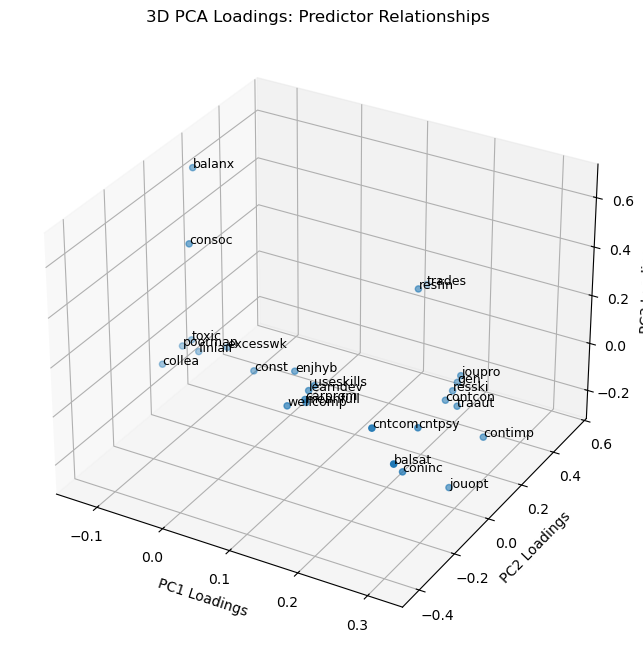

In [65]:
pca = PCA(n_components=3)
pca.fit(X_combined)
loadings = pca.components_.T
explained_variance = pca.explained_variance_ratio_

df_variance = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(len(explained_variance))],
    'Explained Variance Ratio': explained_variance,
    'Explained Variance (%)': explained_variance * 100
})
print(df_variance)

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(loadings[:,0], loadings[:,1], loadings[:,2])

for i, col in enumerate(X_combined.columns):
    ax.text(loadings[i,0], loadings[i,1], loadings[i,2], col, fontsize=9)

ax.set_xlabel('PC1 Loadings')
ax.set_ylabel('PC2 Loadings')
ax.set_zlabel('PC3 Loadings')
ax.set_title('3D PCA Loadings: Predictor Relationships')

plt.show()

In [66]:
# Lasso Regression

X = X_combined.drop(columns='const')
y = df['Preparedness Levels']

lasso_pipeline = make_pipeline(StandardScaler(), LassoCV(cv=5, random_state=42))

lasso_pipeline.fit(X, y)

lasso = lasso_pipeline.named_steps['lassocv']
coef = pd.Series(lasso.coef_, index=X.columns)

selected_features = coef[coef != 0].index.tolist()
print("Selected predictors via Lasso:", selected_features)

X_selected = sm.add_constant(X[selected_features])
model_selected = sm.OLS(y, X_selected).fit()
print(model_selected.summary())

Selected predictors via Lasso: ['balanx', 'balsat', 'cntcom', 'consoc', 'contcon', 'contimp', 'gen', 'jouopt', 'joupro', 'resfin', 'resski', 'traaut', 'trades', 'carprom', 'collea', 'enjhyb', 'excesswk', 'finlair', 'learndev', 'meanfull', 'poorman', 'toxic', 'useskills', 'wellcomp']
                             OLS Regression Results                            
Dep. Variable:     Preparedness Levels   R-squared:                       0.872
Model:                             OLS   Adj. R-squared:                  0.871
Method:                  Least Squares   F-statistic:                     1178.
Date:                 Sun, 29 Jun 2025   Prob (F-statistic):               0.00
Time:                         13:18:41   Log-Likelihood:                -3462.7
No. Observations:                 4171   AIC:                             6975.
Df Residuals:                     4146   BIC:                             7134.
Df Model:                           24                                      

As can be seen from Lasso regression, it does not help to solve the parsimony problem, as such, a forward stepwise selection was chosen

In [67]:
stepwise_model, stepwise_features = forward_selection(X, y)
print(stepwise_model.summary())
print(stepwise_features)

                             OLS Regression Results                            
Dep. Variable:     Preparedness Levels   R-squared:                       0.872
Model:                             OLS   Adj. R-squared:                  0.871
Method:                  Least Squares   F-statistic:                     1885.
Date:                 Sun, 29 Jun 2025   Prob (F-statistic):               0.00
Time:                         13:18:49   Log-Likelihood:                -3465.8
No. Observations:                 4171   AIC:                             6964.
Df Residuals:                     4155   BIC:                             7065.
Df Model:                           15                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.2479      0.049    106.53

In [78]:
# Elastic CV 
elastic_model = make_pipeline(
    StandardScaler(),
    ElasticNetCV(cv=5, l1_ratio=[0.1, 0.5, 1.0], random_state=42)
)
elastic_model.fit(X_combined, y)
enet = elastic_model.named_steps['elasticnetcv']

In [79]:
coef = pd.Series(enet.coef_, index=X_combined.columns)
selected_features = coef[coef != 0].index.tolist()
print("Selected features:", selected_features)

Selected features: ['balanx', 'balsat', 'cntcom', 'consoc', 'contcon', 'contimp', 'gen', 'jouopt', 'joupro', 'resfin', 'resski', 'traaut', 'trades', 'carprom', 'collea', 'enjhyb', 'excesswk', 'finlair', 'learndev', 'meanfull', 'poorman', 'toxic', 'useskills', 'wellcomp']


In [80]:
selected_features = coef[coef != 0].index.tolist()
X_reduced = sm.add_constant(X_combined[selected_features])
ols_model = sm.OLS(y, X_reduced).fit()
print(ols_model.summary())

                             OLS Regression Results                            
Dep. Variable:     Preparedness Levels   R-squared:                       0.872
Model:                             OLS   Adj. R-squared:                  0.871
Method:                  Least Squares   F-statistic:                     1178.
Date:                 Sun, 29 Jun 2025   Prob (F-statistic):               0.00
Time:                         13:23:57   Log-Likelihood:                -3462.7
No. Observations:                 4171   AIC:                             6975.
Df Residuals:                     4146   BIC:                             7134.
Df Model:                           24                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.2302      0.053     98.54

In [82]:
X_refined = df[['balanx', 'balsat', 'gen', 'joupro', 'resski', 'trades', 'collea', 'enjhyb', 'excesswk', 'finlair', 'meanfull', 'poorman', 'wellcomp']]
X_refined = sm.add_constant(X_refined)
ols_refined_model = sm.OLS(y, X_refined).fit()
print(ols_refined_model.summary())

                             OLS Regression Results                            
Dep. Variable:     Preparedness Levels   R-squared:                       0.872
Model:                             OLS   Adj. R-squared:                  0.871
Method:                  Least Squares   F-statistic:                     2173.
Date:                 Sun, 29 Jun 2025   Prob (F-statistic):               0.00
Time:                         13:32:42   Log-Likelihood:                -3468.6
No. Observations:                 4171   AIC:                             6965.
Df Residuals:                     4157   BIC:                             7054.
Df Model:                           13                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.2747      0.048    110.48

In [84]:
# Extract the predictors (emotional and workplace factors) and outcome (Preparedness Level)
X = df.iloc[:,17:69]
X = sm.add_constant(X)
y = df['Preparedness Levels']

# Build an OLS model to fit all factors
model = sm.OLS(y, X).fit()
print(model.summary())

                             OLS Regression Results                            
Dep. Variable:     Preparedness Levels   R-squared:                       0.878
Model:                             OLS   Adj. R-squared:                  0.877
Method:                  Least Squares   F-statistic:                     570.2
Date:                 Sun, 29 Jun 2025   Prob (F-statistic):               0.00
Time:                         13:37:02   Log-Likelihood:                -3363.2
No. Observations:                 4171   AIC:                             6832.
Df Residuals:                     4118   BIC:                             7168.
Df Model:                           52                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.2853      0.054     98.11

#### Initial Observations

From fitting a model on the data with all explicit and implicit emotional and workplace predictors, it is clear that some factors are more predictive than others of career preparedness levels. To note, this approach was done initially with 52 factors, which is indeed not parsimonious and yields a poor model that would likely not generalise too well. That being said, an R^2 value of 0.87 was returned, demonstrating that 87% of the variance in the preparedness levels could be explained by these factors. Not including the personality factors and demographic variables, this actually performs decently well.

The statistically significant factors at the p<0.05 level according to the analysis are: `lcntcom`, `lcntpsy`, `lgen`, `ljoupro`, `lresski`, `ltrades`, `lenjhyb`, `lexcesswk`, `lfinlair`, `lmeanfull`, `lwellcomp`, `fbalsat`, `fcntcom`, `fcontcon`, `fgen`, `fcollea`.

This is interesting, since despite 52 factors, it is clear to see that only 16 of them are actually statistically significant. Furthermore, there are clearly differences in the explicit and implicit reports that are clearly affecting the model. Comparing the values, it appears that only these factors are truly aligned.

In emotional factors:
- Containers - I'm comfortable where I am
- General - I'm ready for my next step

In [94]:
# To enhance the parsimony of the model, let's now model solely on the relevant and significant factors
X = df[['lcntcom', 'lcntpsy', 'lgen', 'ljoupro', 'lresski', 'ltrades', 'lenjhyb', 'lexcesswk', 'lfinlair', 'lmeanfull', 'lwellcomp', 'fbalsat', 'fcntcom', 'fcontcon', 'fgen', 'fcollea']]
# X = df[['lcntcom', 'lgen', 'ltrades', 'lenjhyb', 'lexcesswk', 'lfinlair', 'lmeanfull', 'lwellcomp', 'fbalsat', 'fcntcom', 'fcontcon', 'fgen', 'fcollea']]
X = sm.add_constant(X)
y = df['Preparedness Levels']

# Build an OLS model to fit all factors
model = sm.OLS(y, X).fit()
print(model.summary())

                             OLS Regression Results                            
Dep. Variable:     Preparedness Levels   R-squared:                       0.877
Model:                             OLS   Adj. R-squared:                  0.876
Method:                  Least Squares   F-statistic:                     1845.
Date:                 Sun, 29 Jun 2025   Prob (F-statistic):               0.00
Time:                         14:07:42   Log-Likelihood:                -3387.1
No. Observations:                 4171   AIC:                             6808.
Df Residuals:                     4154   BIC:                             6916.
Df Model:                           16                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.3623      0.039    138.32

From fitting a multiple regression model on a select number of factors, it is clearly to see that the R^2 has not really been sacrificed with regards to explaining the variance despite removing 36 factors in explanation. This also ensures greater parsimony of the model.

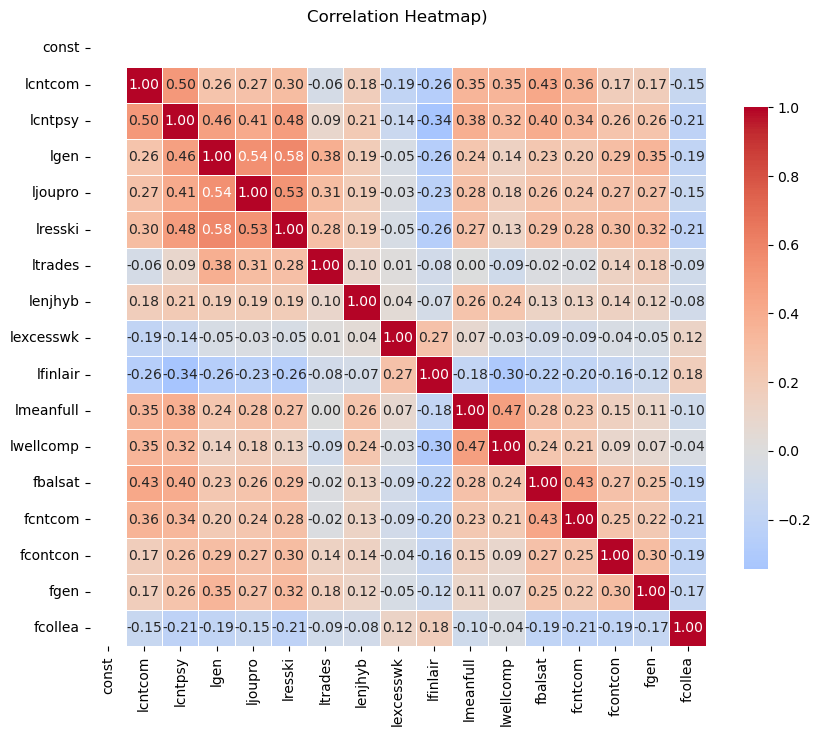

In [86]:
# Identify collinearity between variables
corr = X.corr()

plt.figure(figsize=(10,8))
sns.heatmap(
    corr,
    annot=True,
    cmap='coolwarm',
    center=0,
    linewidths=0.5,
    cbar_kws={"shrink": 0.75},
    fmt=".2f",
    square=True
)
plt.title(f"Correlation Heatmap)")
plt.show()

In [91]:
# Investigate the interaction effects with lgen
desc = """
# Regressions
lcntpsy ~ lgen
ljoupro ~ lgen
lresski ~ lgen

outcome ~ lcntpsy + ljoupro + lresski + lgen
"""

model = Model(desc)
model.fit(df)

estimates = model.inspect()
print(estimates)

       lval  op     rval     Estimate   Std. Err    z-value       p-value
0   lcntpsy   ~     lgen     0.494699   0.011720  42.208865  0.000000e+00
1   ljoupro   ~     lgen     0.575069   0.011660  49.319017  0.000000e+00
2   lresski   ~     lgen     0.562343   0.010614  52.980916  0.000000e+00
3   outcome   ~  lcntpsy     0.000334   0.000335   0.997610  3.184687e-01
4   outcome   ~  ljoupro     0.001618   0.000337   4.806373  1.536931e-06
5   outcome   ~  lresski     0.002960   0.000370   8.003094  1.110223e-15
6   outcome   ~     lgen     0.023702   0.000415  57.076272  0.000000e+00
7   lcntpsy  ~~  lcntpsy  1409.505341  30.864669  45.667275  0.000000e+00
8   ljoupro  ~~  ljoupro  1395.091111  30.549033  45.667275  0.000000e+00
9   lresski  ~~  lresski  1155.994022  25.313401  45.667275  0.000000e+00
10  outcome  ~~  outcome     0.659479   0.014441  45.667275  0.000000e+00


### Compare Explicit vs Implicit Predictors

In [109]:
# Paired T-Test (Assumption of Normality)
def columnwise_ttests(df):
    emotional_explicit = df.iloc[:, 17:32]
    emotional_implicit = df.iloc[:, 43:58]
    workplace_explicit = df.iloc[:, 32:43]
    workplace_implicit = df.iloc[:, 58:69]

    print("Emotional Explicit vs Implicit per column:")
    for i, col_name in enumerate(emotional_explicit.columns):
        ttest_res = stats.ttest_rel(emotional_explicit.iloc[:, i], emotional_implicit.iloc[:, i])
        print(f"{col_name[1:]} - t = {ttest_res.statistic:.4f}, p = {ttest_res.pvalue:.4f}")

    print("\nWorkplace Explicit vs Implicit per column:")
    for i, col_name in enumerate(workplace_explicit.columns):
        ttest_res = stats.ttest_rel(workplace_explicit.iloc[:, i], workplace_implicit.iloc[:, i])
        print(f"{col_name[1:]} - t = {ttest_res.statistic:.4f}, p = {ttest_res.pvalue:.4f}")

# Wilcoxon (Where normality may be violated)
def columnwise_wilcoxon(df):
    emotional_explicit = df.iloc[:, 17:32]
    emotional_implicit = df.iloc[:, 43:58]
    workplace_explicit = df.iloc[:, 32:43]
    workplace_implicit = df.iloc[:, 58:69]

    print("Emotional Explicit vs Implicit per column (Wilcoxon signed-rank test):")
    for i, col_name in enumerate(emotional_explicit.columns):
        stat, p = stats.wilcoxon(emotional_explicit.iloc[:, i], emotional_implicit.iloc[:, i])
        print(f"{col_name} - statistic = {stat:.4f}, p = {p:.4f}")

    print("\nWorkplace Explicit vs Implicit per column (Wilcoxon signed-rank test):")
    for i, col_name in enumerate(workplace_explicit.columns):
        stat, p = stats.wilcoxon(workplace_explicit.iloc[:, i], workplace_implicit.iloc[:, i])
        print(f"{col_name} - statistic = {stat:.4f}, p = {p:.4f}")

def shapiro_diff_test(df):
    emotional_explicit = df.iloc[:, 17:32]
    emotional_implicit = df.iloc[:, 43:58]
    workplace_explicit = df.iloc[:, 32:43]
    workplace_implicit = df.iloc[:, 58:69]

    print("Shapiro-Wilk test for normality of differences (Explicit - Implicit):\n")

    print("Emotional indices:")
    for i, col_name in enumerate(emotional_explicit.columns):
        diff = emotional_explicit.iloc[:, i] - emotional_implicit.iloc[:, i]
        stat, p = stats.shapiro(diff)
        print(f"{col_name} - W = {stat:.4f}, p = {p:.4f}")

    print("\nWorkplace indices:")
    for i, col_name in enumerate(workplace_explicit.columns):
        diff = workplace_explicit.iloc[:, i] - workplace_implicit.iloc[:, i]
        stat, p = stats.shapiro(diff)
        print(f"{col_name} - W = {stat:.4f}, p = {p:.4f}")

In [111]:
columnwise_wilcoxon(df)

Emotional Explicit vs Implicit per column (Wilcoxon signed-rank test):
lbalanx - statistic = 3437394.0000, p = 0.0000
lbalsat - statistic = 4040274.5000, p = 0.0002
lcntcom - statistic = 4165219.0000, p = 0.0340
lcntpsy - statistic = 2594110.5000, p = 0.0000
lconinc - statistic = 2568399.5000, p = 0.0000
lconsoc - statistic = 2766889.5000, p = 0.0000
lcontcon - statistic = 2524248.5000, p = 0.0000
lcontimp - statistic = 2569301.5000, p = 0.0000
lgen - statistic = 2203193.0000, p = 0.0000
ljouopt - statistic = 3157328.0000, p = 0.0000
ljoupro - statistic = 2543313.0000, p = 0.0000
lresfin - statistic = 3110685.0000, p = 0.0000
lresski - statistic = 1849284.0000, p = 0.0000
ltraaut - statistic = 2438716.0000, p = 0.0000
ltrades - statistic = 3143689.5000, p = 0.0000

Workplace Explicit vs Implicit per column (Wilcoxon signed-rank test):
lcarprom - statistic = 4073876.0000, p = 0.0547
lcollea - statistic = 2276776.0000, p = 0.0000
lenjhyb - statistic = 2925868.0000, p = 0.0000
lexcesswk -

In [112]:
X_full = df.iloc[:,17:69]
X_full = sm.add_constant(X_full)
model_full = sm.OLS(y, X_full).fit()

X_explicit = df.iloc[:, 17:43]
X_explicit = sm.add_constant(X_explicit)
model_explicit = sm.OLS(y, X_explicit).fit()

X_implicit = df.iloc[:, 43:69]
X_implicit = sm.add_constant(X_implicit)
model_implicit = sm.OLS(y, X_implicit).fit()

anova_imp = anova_lm(model_explicit, model_full)
print("Contribution of implicit factors (holding explicit constant):")
print(anova_imp)

# ANOVA: Do explicit factors improve model after implicit ones?
anova_exp = anova_lm(model_implicit, model_full)
print("\nContribution of explicit factors (holding implicit constant):")
print(anova_exp)

Contribution of implicit factors (holding explicit constant):
   df_resid          ssr  df_diff      ss_diff           F  Pr(>F)
0    4144.0  2655.663450      0.0          NaN         NaN     NaN
1    4118.0  1225.020578     26.0  1430.642873  184.969808     0.0

Contribution of explicit factors (holding implicit constant):
   df_resid          ssr  df_diff      ss_diff           F  Pr(>F)
0    4144.0  4829.521095      0.0          NaN         NaN     NaN
1    4118.0  1225.020578     26.0  3604.500517  466.030888     0.0


In [115]:
print(f"R² Full Model: {model_full.rsquared:.4f}")
print(f"R² Explicit Model: {model_explicit.rsquared:.4f}")
print(f"R² Implicit Model: {model_implicit.rsquared:.4f}")
print(" " \
"")
print(f"Adj R² Full Model: {model_full.rsquared_adj:.4f}")
print(f"Adj R² Explicit Model: {model_explicit.rsquared_adj:.4f}")
print(f"Adj R² Implicit Model: {model_implicit.rsquared_adj:.4f}")

R² Full Model: 0.8780
R² Explicit Model: 0.7356
R² Implicit Model: 0.5192
 
Adj R² Full Model: 0.8765
Adj R² Explicit Model: 0.7340
Adj R² Implicit Model: 0.5162


From the comparison, it is clear to see that the overall contribution of explicit factors for career preparedness is higher than for implicit factors

### 2. Analyse Key Themes and Drivers

### 3. Show how factor importance varies by country

Using multi-level modelling

In [44]:
df['outcome'] = df['Preparedness Levels']
X = df[['lcntcom', 'lcntpsy', 'lgen', 'ljoupro', 'lresski', 'ltrades', 'lenjhyb', 'lexcesswk', 'lfinlair', 'lmeanfull', 'lwellcomp', 'fbalsat', 'fcntcom', 'fcontcon', 'fgen', 'fcollea']]

formula = 'outcome ~ ' + ' + '.join(X)

df['Country'] = df['Country'].astype('category')

In [45]:
model = smf.mixedlm(formula, df, groups=df["Country"])
result = model.fit()
print(result.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: outcome   
No. Observations: 4171    Method:             REML      
No. Groups:       6       Scale:              0.2947    
Min. group size:  580     Log-Likelihood:     -3490.4888
Max. group size:  1193    Converged:          Yes       
Mean group size:  695.2                                 
--------------------------------------------------------
             Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept     5.359    0.049 109.498 0.000  5.263  5.454
lcntcom      -0.001    0.000  -2.689 0.007 -0.001 -0.000
lcntpsy      -0.000    0.000  -1.196 0.232 -0.001  0.000
lgen          0.021    0.000  87.768 0.000  0.020  0.021
ljoupro       0.001    0.000   2.625 0.009  0.000  0.001
lresski       0.001    0.000   3.960 0.000  0.000  0.001
ltrades       0.001    0.000   7.039 0.000  0.001  0.002
lenjhyb       0.001    0.000   4.208 0.00

/Users/raymondguo/opt/anaconda3/envs/cowryenv/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [46]:
country_effects = pd.DataFrame(result.random_effects).T
country_effects.columns = ['intercept']
country_effects = country_effects.sort_values(by='intercept', ascending=False)

<Figure size 1000x600 with 0 Axes>

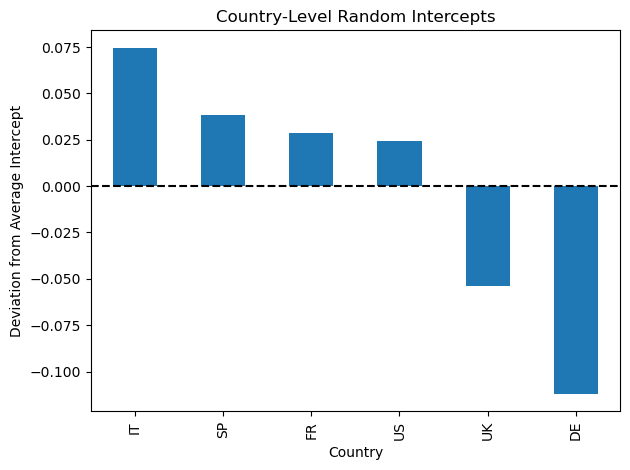

In [47]:
plt.figure(figsize=(10, 6))
country_effects.plot(kind='bar', legend=False)
plt.axhline(0, color='black', linestyle='--')
plt.title("Country-Level Random Intercepts")
plt.ylabel("Deviation from Average Intercept")
plt.xlabel("Country")
plt.tight_layout()
plt.show()